# What's this?

This notebook describes an analysis of measurements taken from a Core417I board (the one like [Core 407I](http://www.waveshare.com/wiki/Core407I) but featuring a version of the STM32F4 chip with HW crypto accelerator). The board together with a custom sofware package is available from Riscure as a training target dubbed [Piñata](https://www.riscure.com/product/pinata-training-target/). Since vanilla Piñata software doesn't do HMAC SHA1, I (@ceesb) cut and paste some of ST's reference code. Then, I added a command on the Piñata that feeds back a SHA1 output into the HMAC SHA1 computation so that Piñata does many HMACs per input sent from the PC:

```
i = 0
iterations = MSB_UINT32(readfromserial(4))
input = readfromserial(20)
for i < iterations:
   triggerUP()
   output = HMACSHA1(input)
   triggerDOWN()
   input = SHA1(input)
   i++
writetoserial(output)
```

It can be run from the PC by sending a message with command 0xdf:

```
=>   df <UINT32 MSB iterations> <20 bytes MSB input>
<=   <20 bytes output of last HMAC SHA1 iteration>
```

Send me (@ceeesb) a ping for the binary.

# Acquisition

[Riscure EM probe (LS)](https://www.riscure.com/product/em-probe-station/) over the chip, right in the middle.

Picoscope in rapid block mode, 4096 encryptions per scope fetch.  On receiving the 4096 traces on the PC we compute the inputs and store them in a trace set. Since we know the key, we verify that the last HMAC output of the Piñata matches with what we expect, so we know for sure all traces match the inputs. Obviously the acquisition is done with a Julia script, similar to piposcope.jl in Jlsca's example folder, but send me a ping if you want it.

Acquired > 1M traces of 3900 samples at 1Gs/s in *less than 15 minutes*. 3.5Gb 7-zipped trace set [here](https://drive.google.com/open?id=0B-My9BsChztIM21sdWxWRWRrZGs).

# Attack

The attack is the same as described in Section 3.4 in this [paper](https://link.springer.com/chapter/10.1007/978-3-319-25915-4_19) by Belaid and others.

We're going to take a look at SHA1 HMAC using the input. The key itself cannot be recovered since there is no differential data being mixed with the key. The two SHA1 states themselves are sufficient to create arbitrary HMACs. One can also attack the outer SHA1 using an output attack, but this is not shown here (although [Jlsca](https://github.com/Riscure/Jlsca) implements this attack too). We'll only be looking at the inner SHA1.

To explain this attack, we first define some terms:
* a0,b0,c0,d0,e0: the 160-bit SHA1 state we are to recover, in 5 32-bit numbers
* W0 - W3: the attacker controlled and known 32-bit inputs
* T0-T3: the value of T for rounds 0-3
* F0-F3: the output value of the F function for rounds 0-3
* Rot(x,a): rotates x left by a bits
* Ch(a,b,c) = (a & b) XOR (~a & c)

We then roll out first 4 rounds of the inner SHA1 loop in the terms defined above:
```
T0 = Rot(a0, 5) + Ch(b0, c0, d0) + e0 + 0x5a827999 + W0
F0 = Ch(b0, c0, d0)

T1 = Rot(T0, 5) + Ch(a0, Rot(b0, 30), c0) + d0 + 0x5a827999 + W1
F1 = Ch(a0, Rot(b0, 30), c0)

T2 = Rot(T1, 5) + Ch(T0, Rot(a0, 30), Rot(b0, 30)) + c0 + 0x5a827999 + W2
F2 = Ch(T0, Rot(a0, 30), Rot(b0, 30))

T3 = Rot(T2, 5) + Ch(T1, Rot(T0, 30), Rot(a0, 30)) + Rot(b0, 30) + 0x5a827999 + W3
F3 = Ch(T1, Rot(T0, 30), Rot(a0, 30))
```

The SHA1 input attack steps are then:
1. DPA attack on 32-bit modular addition to guess "Rot(a0, 5) + Ch(b0, c0, d0)" and predict "T0" since we know "W0" 
2. DPA attack on 32-bit modular addition to guess "Ch(a0, Rot(b0, 30), c0) + d0" and predict "T1" since we know "W1" and "Rot(T0, 5)" 
3. DPA attack on Ch function to guess "Rot(a0, 30)" and predict "F3" since we know "T1" and "Rot(T0, 30)" 
4. DPA attack on Ch function to guess "Rot(b0, 30)" and predict "F2" since we know "T0" and "Rot(a0, 30)"
5. DPA attack on 32-bit modular addition to guess "c0" and predict "T2" since we know "Rot(T1, 5) + Ch(T0, Rot(a0, 30), Rot(b0, 30))" and "W2" 

These 5 attacks allow us to recover the secret SHA1 state a0,b0,c0,d0,e0.  DPA attacks 1-5 are recovering 32-bit numbers and in order to enumerate the guesses we need to split the attacks up in smaller (typically 8-bits or less) attack so that the key space can be enumerated. How to split up the attacks is described in this [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.94.7333&rep=rep1&type=pdf) by Lemke, Schramm and Paar. Note that DPA attack n depends on the output of attack n-1 for n > 1. In Jlsca terms we'd call these attack *phases*. For DPA 3 and 4 multiple parts of the secret can be recovered simulteaneously since they're independent. Within a *phase* you can therefore have multiple *targets*. 

In Jlsca, the SHA1 attack is split up in phases and targets as follows:

* Phase 1, target 1: byte 0 of DPA 1
* Phase 2, target 1: byte 1 of DPA 1
* Phase 3, target 1: byte 2 of DPA 1
* Phase 4, target 1: byte 3 of DPA 1

* Phase 5, targets 1-8, 8 nibbles of DPA 2. The reason we attack nibbles is that we constructed the Ch target function to take 2 4-bits inputs and produces one 4-output. We can easily conditionally average on 2 4-bit (8-bits) of input, but not much more than that.

* Phase 6, targets 1-4, 4 bytes of DPA 3. The reason we *don't* attack nibbles here is that one of the Ch target function inputs, Rot(b0,30), is a constant. Since it's constant, it doesn't affect the average so we can take 8-bits of the T0 input to Ch and guess an 8-bits output.

* Phase 7, target 1: byte 0 of DPA 4
* Phase 8, target 1: byte 1 of DPA 4
* Phase 9, target 1: byte 2 of DPA 4
* Phase 10, target 1: byte 3 of DPA 4

* Phase 11, target 1: byte 0 of DPA 5
* Phase 12, target 1: byte 1 of DPA 5
* Phase 13, target 1: byte 2 of DPA 5
* Phase 14, target 1: byte 3 of DPA 5


Note also that this attack only uses the first 12 bytes of the input! (W0, W1 and W2)

Note also that for HMAC we need to perform the SHA1 attack two times, but we don't in this notebook. 

In [1]:
# add two local workers in addition to the master process
addprocs(2)

# import the necessary stuff on each process
@everywhere begin
    using Jlsca.Trs
    using Jlsca.Sca
    using Jlsca.Sca.sca
    using Jlsca.Sca.hw
    using Jlsca.Sha
    using Jlsca.Align
    using ProgressMeter
end

# plotting libs are local only
using PyPlot.plot,PyPlot.figure,PyPlot.title,PyPlot.subplots

using Base.Threads

@printf("#procs:              %d\n", nprocs())
@printf("#workers:            %d\n", nworkers())
@printf("#threads per worker: %d\n", nthreads())

INFO: Recompiling stale cache file /data/home/ceesb/.julia/lib/v0.6/Jlsca.ji for module Jlsca.
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
No working GUI backend found for matplotlib
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#procs:              3
#workers:            2
#threads per worker: 10


In [2]:
@everywhere begin
    # for testing if this notebook is working correctly
    emulation = true
    
    if emulation
        trs = InspectorTrace("../jlsca/shatraces/sha1_67452301efcdab8998badcfe10325476c3d2e1f0.trs")
        # first 32 samples contain all the necessary target intemediates
        addSamplePass(trs, x -> x[1:32])
        # convert the intermediates to the necessary leakages for this attack to work
        addSamplePass(trs, x -> vcat(hw.(x), hw.(x .& 0xf), hw.(x .>> 4)))
        # 16 bytes input, 20 bytes output in this trace set 
        inputLength = 16
        # where the peaks are
        rangeOfInterest = 1:200
    else
        trs = InspectorTrace("pinatahmacsha1.trs")
        # a dirty hack to make Jlsca interpret this data as signed (don't change this to types with different sizes, 
        # or bad fail)
        trs.sampleType = Int8
        # only 20 inputs in this trace set, there's no output
        inputLength = 20
        # where the inner SHA1 is (how this region is determined is explained below)
        rangeOfInterest = 900:2100
    end
end

Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20
	From worker 2:	Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20
	From worker 3:	Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20


In [3]:
# sets up a static align pass

if !emulation 
    @everywhere begin
        popSamplePass(trs)

        # how much we are willing to move to find an optimum correlation with the reference
        maxShift = 100
        # where you want the reference to be placed in the result. Setting this to 1 will place it at the beginning.
        referenceOffset = 900
        # how long the reference is
        referenceLength = 600
        # the reference data itself. Can come from anywhere, but here we extract it from one of traces
        reference = trs[1][2][referenceOffset:referenceOffset+referenceLength-1]
        # drop traces that correlate less than this minimum
        corvalMin = 0.0
        # use the FFTW correlator with the above settings
        alignstate = CorrelationAlignFFT(reference, referenceOffset, maxShift)
        # caches the shift and correlation values, so that in a given process it's only computed once for each trace
        alignpass = AlignPass(alignstate, length(trs), corvalMin)

        addSamplePass(trs, alignpass)
    end
end

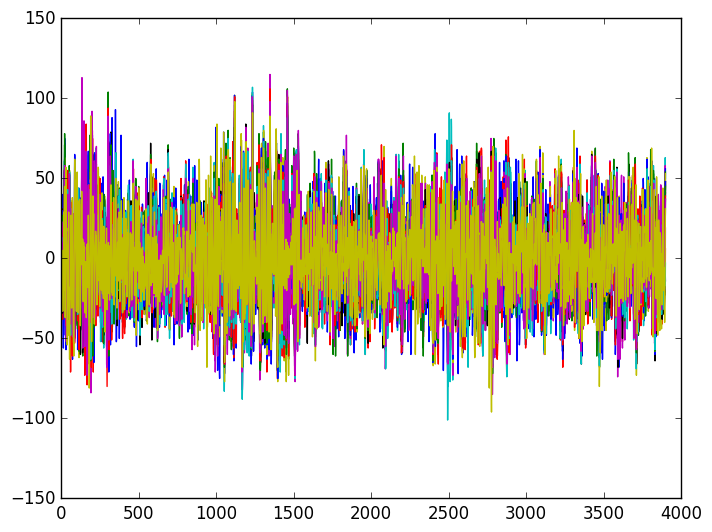

In [4]:
# show a few traces in the same window
for i in 1:20
    plot(trs[i][2])
end

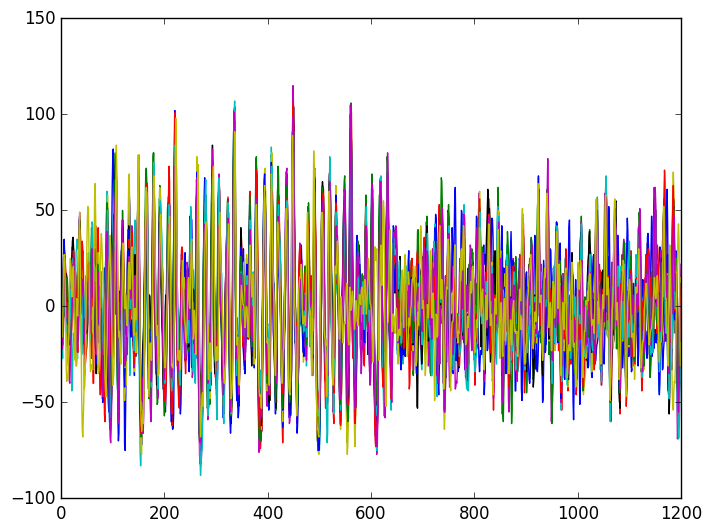

In [5]:
# zoomed in to check the alignment
for i in 1:20
    plot(trs[i][2][rangeOfInterest])
end


In [6]:
# helper functions for the known key analysis

@everywhere begin
    # will contain the secret inner SHA1 state, used for correlating with intermediates under known key scenario
    # (i.e. known key analysis)
    innerstate = sha1init()
    if emulation
        knownkeyinner = [0x00 for i in 1:20]
        knownkeyinner = hex2bytes("67452301efcdab8998badcfe10325476c3d2e1f0")
    else
        # the master key used for HMAC SHA1 on the pinata
        key = hex2bytes("cafebabedeadbeef0001020304050607cafebabedeadbeef")
        # the inner SHA1 key is derived from the master key by a hash
        innerkey = Sha.K0(key) .⊻ 0x36
        update(innerstate, innerkey)
        # the secret state of the inner SHA1, passed as a known key into the attack later
        knownkeyinner = reinterpret(UInt8, map(hton, innerstate.H))
        # will contain the secret inner SHA1 state, used for known key analysis later
        outerstate = sha1init()
        # the outer SHA1 key is derived from the master key by a hash        
        outerkey = Sha.K0(key) .⊻ 0x5c
        update(outerstate, outerkey)
        # the secret state of the outer SHA1
        knownkeyouter = reinterpret(UInt8, map(hton, outerstate.H))
    end

    # computes the output the inner SHA1, used for known key analysis
    function inneroutput(innerstate::Sha1state, msg::Vector{UInt8})
        state = deepcopy(innerstate)
        update(state, msg)
        return final(state)
    end

    # given the known inner SHA1 key computes the HD between 0,T0 T0,T1 T1,T2, T2,T3
    function attackableHDT(msg::Vector{UInt8})
        data = zeros(UInt32, 4)
        cnt = Ref(1)
        innerstate2 = deepcopy(innerstate)
        update(innerstate2, msg[1:inputLength])
        final(innerstate2, (x,y) -> x == "T" && cnt.x <= length(data) ? (data[cnt.x] = y; cnt.x += 1) : nothing)
        xor = 0x00000000
        for i in 1:length(data)
            tmp = data[i]
            data[i] ⊻= xor
            xor = tmp
        end
        return map(hton, data)
    end
    
    # given the known inner SHA1 key computes the HD between T0,W0 T1,W1 T2,W2, T3,W3
    # our trace set doesn't leak this though ..
    function attackableHDIn(msg::Vector{UInt8})
        data = zeros(UInt32, 4)
        cnt = Ref(1)
        innerstate2 = deepcopy(innerstate)
        update(innerstate2, msg[1:inputLength])
        final(innerstate2, (x,y) -> x == "T" && cnt.x <= length(data) ? (data[cnt.x] = y; cnt.x += 1) : nothing)
        for i in 1:length(data)
            data[i] ⊻= Sca.getInt(i,msg)
        end
        return map(hton, data)
    end
end


# Helper for computing correlation for known key analysis. We don't define this in the @everwhere macro, since we 
# only need it on the  master process. It uses IncrementalCovarianceTiled which is threaded, and macro @parallel to
# run it on different processes.
function correlateDataSamples()
    @everywhere begin 
        ic = IncrementalCovarianceTiled(length(trs[1][1]), length(trs[1][2]))
        getIc() = ic
    end
    
    @sync @parallel for t in 1:len
        trs = getTrs()
        ic = getIc()
        (data, samples) = trs[t]
        if length(data) == 0 || length(samples) == 0
            continue
        end
        add!(ic, data, samples)
    end
        
    
    for w in workers()
        if w != myid()
            add!(ic, @fetchfrom w getIc())
        end
    end
    
    C = getCorr(ic)
    return abs.(C)
end

correlateDataSamples (generic function with 1 method)

We first want to determine in time when the inner SHA1 computation is happening. Inner SHA1 consumes the input, the next code block compute the correlation of samples with the HW of the input, and then plot it. We'll see large spikes from around sample 900 onwards.

In [7]:
# byte-wise HW of input correlated with samples
@everywhere begin
    addDataPass(trs, x -> Sca.hw.(x))
    addSamplePass(trs, x -> abs.(x))
end

@time C1 = correlateDataSamples()

@everywhere begin
    popDataPass(trs)
    popSamplePass(trs)
end

 76.851266 seconds (1.41 M allocations: 82.409 MiB, 0.05% gc time)


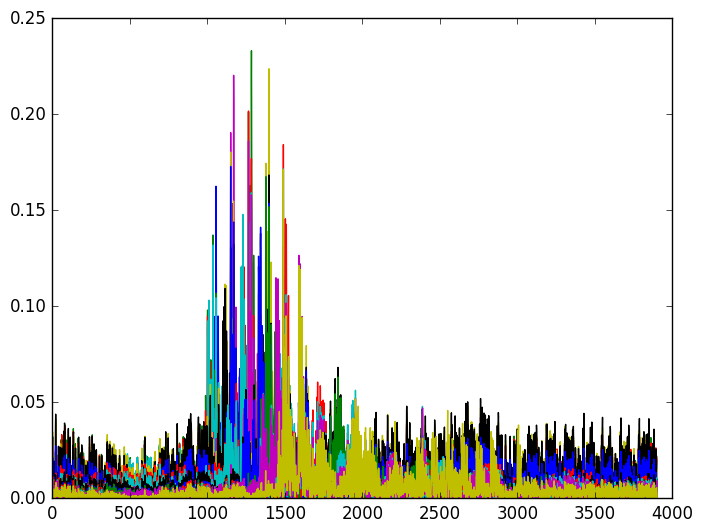

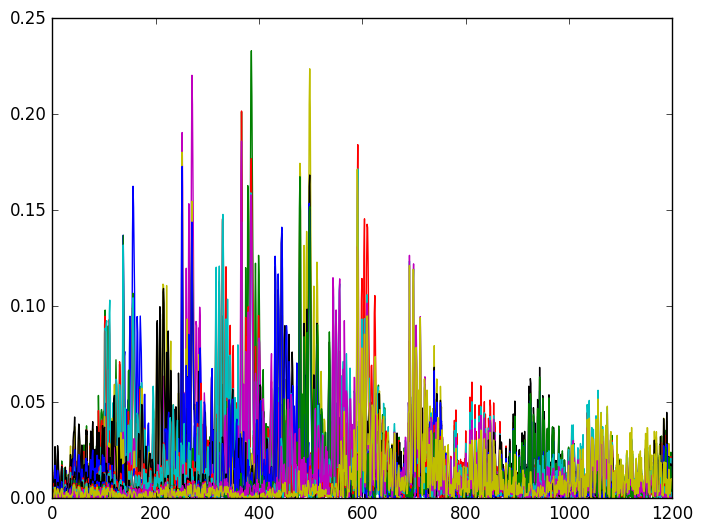

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7f7da7fc4810>)

In [8]:
# overall picture of HW input correlation
plot(C1')
figure()

# zoomed in
plot(C1[:,rangeOfInterest]')
figure()


Now let's find the output of the inner SHA1. We'll correlate with HW of 32-bits at the time to get a bit stronger signal. We'll find two peaks, one around sample 2100 and one near the end at 3500. The last one is (probably) caused by the outer SHA1 overwriting the inner SHA1 output. We'll use 900:2100 as the range for the inner SHA1 computation.

In [9]:
# byte-wise HW of inner SHA1 output correlated with samples
@everywhere begin
    addDataPass(trs, x -> inneroutput(innerstate,x[1:inputLength]))
    addDataPass(trs, x -> Sca.hw.(reinterpret(UInt32, x)))
    addSamplePass(trs, x -> abs.(x))
end

@time C2 = correlateDataSamples()

@everywhere begin
    popDataPass(trs)
    popDataPass(trs)
    popSamplePass(trs)
end


 40.224091 seconds (159.63 k allocations: 15.189 MiB)


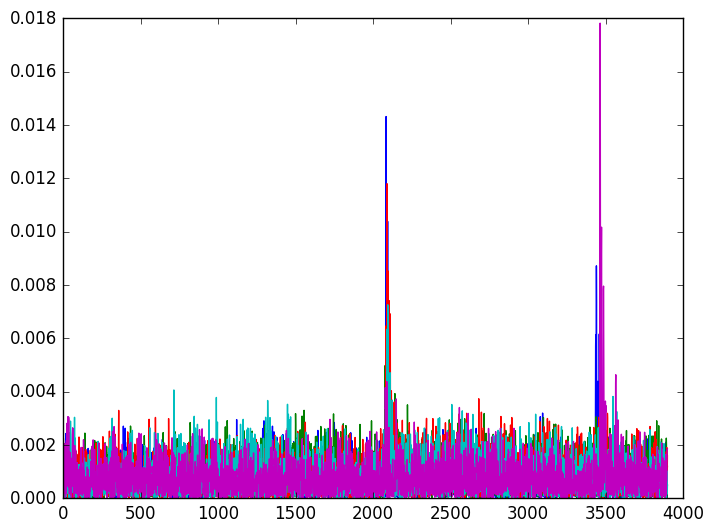

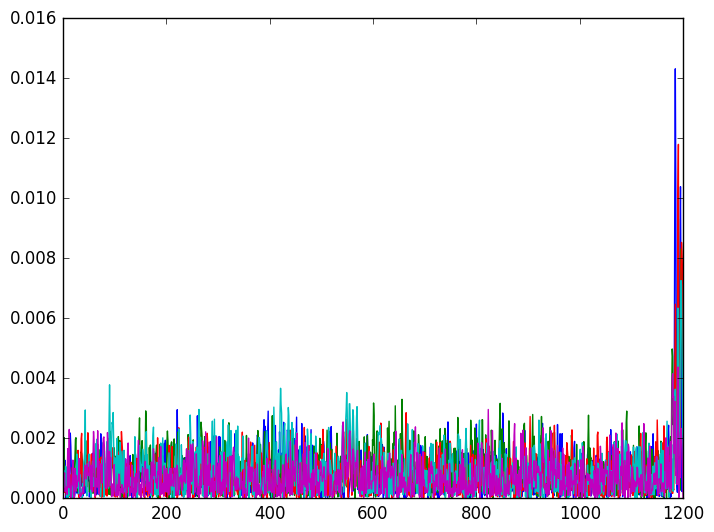

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7f7da7dc5690>)

In [10]:
# overall picture of HW SHA1 output correlation
plot(C2')
figure()

# zoomed in
plot(C2[:,rangeOfInterest]')
figure()

Now we want to perform the attack described above. We'll use conditional averaging to speed things up. We will use Hamming weight as a leakage model, and store the correlation matrix for each attack. In total we'll get 24 correlation matrices, which we'll plot, marking the correlation of each correct hypothesis in red.

In [11]:
function allocateCbData(params::DpaAttack)
    phases = numberOfPhases(params.attack)
    leakages = Sca.getNrLeakageFunctions(params.analysis)
    c = Vector{Vector{Vector{AbstractArray{Float64,2}}}}(phases)
    
    for phase in 1:phases
        targets = numberOfTargets(params.attack,phase)
        c[phase] = Vector{Vector{AbstractArray{Float64,2}}}(targets)
        
        for target in 1:targets
            c[phase][target] = Vector{AbstractArray{Float64,2}}(leakages)
        end
    end
    return c
end

@everywhere function corrCb(phase,targetOffset,leakageIdx,c)
#     print("saving corr matrix phase $phase, target $targetOffset, leakage $leakageIdx\n")
    corrMatrices[phase][targetOffset][leakageIdx] = deepcopy(c)
end

function basisModelWUTF(x::Integer, bitWidth=9)
  g = zeros(Float64, bitWidth)
  for i in 1:bitWidth
      g[i] = (x >> (i-1)) & 1
  end

  return g
end

function docondavg()
    attack = Sha1InputAttack()
    analysis = CPA()
    analysis.leakages = [HW()]
    global params = DpaAttack(attack,analysis)
    params.scoresCallBack = Nullable(corrCb)
    params.knownKey = Nullable(knownkeyinner)
#     params.phases = [1,4]
        
    global corrMatrices = allocateCbData(params)
    
    @everywhere addSamplePass(trs, x -> abs.(x))    
    
    @everywhere setPostProcessor(trs, CondAvg(SplitByTracesBlock()))
    @time sca(DistributedTrace(), params, 1,len)
    
    @everywhere popSamplePass(trs)
end

function doinccpa()
    attack = Sha1InputAttack()
    analysis = IncrementalCPA()
    analysis.leakages = [HW()]
    global params = DpaAttack(attack,analysis)
    params.scoresCallBack = Nullable(corrCb)
    params.knownKey = Nullable(knownkeyinner)
#     params.phases = [1,4]
    attack.xor = false
    attack.xorForT0 = 0x00000000
        
    global corrMatrices = allocateCbData(params)
    
    @everywhere addSamplePass(trs, x -> abs.(x))    
    @everywhere setPostProcessor(trs, IncrementalCorrelation(SplitByTracesBlock()))
    
    @time sca(DistributedTrace(), params, 1,len)
    
    @everywhere popSamplePass(trs)
end

function doinccpaHD()
    attack = Sha1InputAttack()
    analysis = IncrementalCPA()
    analysis.leakages = [HW()]
    global params = DpaAttack(attack,analysis)
    params.scoresCallBack = Nullable(corrCb)
    params.knownKey = Nullable(knownkeyinner)
#     params.phases = [1,4]
    attack.xor = true
    attack.xorForT0 = 0x00000000
        
    global corrMatrices = allocateCbData(params)
    
    @everywhere addSamplePass(trs, x -> abs.(x))    
    @everywhere setPostProcessor(trs, IncrementalCorrelation(SplitByTracesBlock()))
    
    @time sca(DistributedTrace(), params, 1,len)
    
    @everywhere popSamplePass(trs)
end

doinccpaHD (generic function with 1 method)

In [12]:
docondavg()


Jlsca running in Julia version: 0.6.0, 3 processes/2 workers/10 threads per worker

SHA1 input attack parameters
T xor:      false
analysis:   CPA
leakages:   Jlsca.Sca.Leakage[HW]
data at:    1
known key:  685d79d6007d6cb9437d9393ce6eacdefbf69a0a

phase: 1 / 14, #targets 1

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:25ays



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 1
rank:   1, candidate: 0x00, peak: 0.981033 @ 1003
rank:   2, candidate: 0xe0, peak: 0.769999 @ 1113
rank:   3, candidate: 0x80, peak: 0.753968 @ 1023
rank:   4, candidate: 0x10, peak: 0.750532 @ 1059
rank: 106, correct  : 0x47, peak: 0.429055 @ 1395
recovered key material: 00

phase: 2 / 14, #targets 1
phase input: 47

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:20



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 2
rank:   1, candidate: 0x00, peak: 0.957738 @ 1011
rank:   2, candidate: 0x80, peak: 0.766702 @ 1057
rank:   3, candidate: 0xff, peak: 0.745644 @ 1164
rank:   4, candidate: 0xfc, peak: 0.648693 @ 1053
rank:  24, correct  : 0xcf, peak: 0.517212 @ 1396
recovered key material: 00

phase: 3 / 14, #targets 1
phase input: 47cf

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:22



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 3
rank:   1, candidate: 0xff, peak: 0.976921 @ 1037
rank:   2, candidate: 0x7f, peak: 0.850926 @ 1040
rank:   3, candidate: 0x03, peak: 0.769033 @ 1005
rank:   4, candidate: 0x01, peak: 0.725308 @ 1108
rank:  22, correct  : 0xa7, peak: 0.577220 @ 1396
recovered key material: ff

phase: 4 / 14, #targets 1
phase input: 47cfa7

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:21



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 4
rank:   1, candidate: 0xff, peak: 0.948149 @ 1038
rank:   2, candidate: 0x00, peak: 0.779104 @ 1039
rank:   3, candidate: 0x7f, peak: 0.703180 @ 1514
rank:   4, candidate: 0x3f, peak: 0.663101 @ 1166
rank:  37, correct  : 0x30, peak: 0.485279 @ 1284
recovered key material: ff

phase: 5 / 14, #targets 1
phase input: 47cfa730

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:20



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 5
rank:   1, candidate: 0x82, peak: 0.395792 @ 1395
rank:   2, correct  : 0x7e, peak: 0.383851 @ 1395
rank:   3, candidate: 0xfe, peak: 0.368506 @ 1395
rank:   4, candidate: 0x02, peak: 0.361301 @ 1396
rank:   5, candidate: 0x6f, peak: 0.302816 @ 2110
recovered key material: 82

phase: 6 / 14, #targets 1
phase input: 47cfa7307e

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:21



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 6
rank:   1, candidate: 0x81, peak: 0.374004 @ 1507
rank:   2, candidate: 0x02, peak: 0.343650 @ 1403
rank:   3, candidate: 0x03, peak: 0.341969 @ 1514
rank:   4, correct  : 0x01, peak: 0.340757 @ 1507
rank:   5, candidate: 0xb7, peak: 0.331639 @ 1397
recovered key material: 81

phase: 7 / 14, #targets 1
phase input: 47cfa7307e01

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:21



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 7
rank:   1, candidate: 0xaf, peak: 0.542707 @ 1507
rank:   2, correct  : 0x2f, peak: 0.541084 @ 1507
rank:   3, candidate: 0x47, peak: 0.452118 @ 1402
rank:   4, candidate: 0xb7, peak: 0.413424 @ 1397
rank:   5, candidate: 0x37, peak: 0.409728 @ 1397
recovered key material: af

phase: 8 / 14, #targets 1
phase input: 47cfa7307e012f

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:23



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 8
rank:   1, correct  : 0x6c, peak: 0.413656 @ 1507
rank:   2, candidate: 0xac, peak: 0.395613 @ 1284
rank:   3, candidate: 0x6b, peak: 0.388699 @ 1397
rank:   4, candidate: 0xec, peak: 0.378900 @ 1507
rank:   5, candidate: 0x2c, peak: 0.349997 @ 1283
recovered key material: 6c

phase: 9 / 14, #targets 8
phase input: 47cfa7307e012f6c

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:57



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 9
rank:   1, candidate: 0x09, peak: 0.350618 @ 1041
rank:   2, candidate: 0x01, peak: 0.349194 @ 1041
rank:   3, candidate: 0x0d, peak: 0.348170 @ 1041
rank:   4, correct  : 0x05, peak: 0.346746 @ 1041
rank:   5, candidate: 0x0b, peak: 0.344456 @ 1041
recovered key material: 09
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 2, phase: 9
rank:   1, candidate: 0x00, peak: 0.339342 @ 1395
rank:   2, candidate: 0x08, peak: 0.330843 @ 1395
rank:   3, candidate: 0x0b, peak: 0.297600 @ 1076
rank:   4, candidate: 0x03, peak: 0.296816 @ 3525
rank:  10, correct  : 0x07, peak: 0.276267 @ 2410
recovered key material: 00
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 3, phase: 9
rank:   1, candidate: 0x03, peak: 0.454644 @ 1043


Processing traces 1:1228800.. 100% Time: 0:00:59



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 10
rank:   1, candidate: 0x74, peak: 0.658454 @ 1041
rank:   2, candidate: 0x7c, peak: 0.632733 @ 1042
rank:   3, candidate: 0x34, peak: 0.603405 @ 1056
rank:   4, candidate: 0x3c, peak: 0.588227 @ 1041
rank:  44, correct  : 0x2e, peak: 0.459934 @ 1041
recovered key material: 74
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 2, phase: 10
rank:   1, candidate: 0x78, peak: 0.603592 @ 1283
rank:   2, candidate: 0x52, peak: 0.594133 @ 1052
rank:   3, candidate: 0x58, peak: 0.573643 @ 1283
rank:   4, candidate: 0x53, peak: 0.566327 @ 1041
rank: 126, correct  : 0x5b, peak: 0.386376 @ 1401
recovered key material: 78
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 3, phase: 10
rank:   1, candidate: 0x1b, peak: 0.779273 @ 10

Processing traces 1:1228800.. 100% Time: 0:00:24



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 11
rank:   1, candidate: 0x3b, peak: 0.320377 @ 3439
rank:   2, candidate: 0x2a, peak: 0.310413 @ 1401
rank:   3, correct  : 0x2c, peak: 0.307641 @ 1638
rank:   4, candidate: 0xaa, peak: 0.297215 @ 317
rank:   5, candidate: 0xbb, peak: 0.293976 @ 3440
recovered key material: 3b

phase: 12 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:22



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 12
rank:   1, correct  : 0x0d, peak: 0.554265 @ 1632
rank:   2, candidate: 0x8d, peak: 0.433158 @ 1632
rank:   3, candidate: 0x0f, peak: 0.359247 @ 1633
rank:   4, candidate: 0x2d, peak: 0.350893 @ 1632
rank:   5, candidate: 0xed, peak: 0.321429 @ 1633
recovered key material: 0d

phase: 13 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c0d

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:20



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 13
rank:   1, correct  : 0x00, peak: 0.504712 @ 1632
rank:   2, candidate: 0x80, peak: 0.456511 @ 1632
rank:   3, candidate: 0xfe, peak: 0.401987 @ 1638
rank:   4, candidate: 0x02, peak: 0.375757 @ 1638
rank:   5, candidate: 0x7e, peak: 0.336004 @ 1638
recovered key material: 00

phase: 14 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c0d00

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:22



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256,)
Results @ 256 rows
target: 1, phase: 14
rank:   1, correct  : 0x9e, peak: 0.520110 @ 1632
rank:   2, candidate: 0x1e, peak: 0.472652 @ 1632
rank:   3, candidate: 0xbe, peak: 0.388035 @ 1632
rank:   4, candidate: 0x3e, peak: 0.361609 @ 1632
rank:   5, candidate: 0xde, peak: 0.343894 @ 1632
recovered key material: 9e
recovered key: e9df4c254c6de1d3437d93a24ef12c4326957428
knownkey match: false
398.538874 seconds (13.32 M allocations: 2.309 GiB, 0.55% gc time)


In [13]:
friendlybanner = [
    ["DPA 1, mod add, byte 0"],
    ["DPA 1, mod add, byte 1"],
    ["DPA 1, mod add, byte 2"],
    ["DPA 1, mod add, byte 3"],
    ["DPA 2, mod add, byte 0"],
    ["DPA 2, mod add, byte 1"],
    ["DPA 2, mod add, byte 2"],
    ["DPA 2, mod add, byte 3"],
    ["DPA 3, bit and, nibble 0",
     "DPA 3, bit and, nibble 1",
     "DPA 3, bit and, nibble 2",
     "DPA 3, bit and, nibble 3",
     "DPA 3, bit and, nibble 4",
     "DPA 3, bit and, nibble 5",
     "DPA 3, bit and, nibble 6",
     "DPA 3, bit and, nibble 7"],
    ["DPA 4, bit and, byte 0",
     "DPA 4, bit and, byte 1",
     "DPA 4, bit and, byte 2",
     "DPA 4, bit and, byte 3"],
    ["DPA 5, mod add, byte 0"],
    ["DPA 5, mod add, byte 1"],
    ["DPA 5, mod add, byte 2"],
    ["DPA 5, mod add, byte 3"]]

# FIXME plot breaks when plotting > 1 leakages
function plotAll()
    (fig,axes) = subplots(nrows=6, ncols=4, figsize=(25, 30), sharey=false)
    rk = correctKeyMaterial(params.attack, get(params.knownKey))
    c = corrMatrices
    count = 0
    for phase in 1:length(c)
        if !isassigned(c, phase)
            continue
        end
        cp = c[phase]

        for target in 1:length(cp)
            if !isassigned(cp, target)
                continue
            end
            cpt = cp[target]
            if !isassigned(cpt, 1)
                continue
            end
            
            @assert Sca.getNrLeakageFunctions(params.analysis) == 1
            
            for leakage in 1:length(cpt)
                cm = cpt[leakage]
                phaseDataOffset = phase > 1 ? sum(x -> numberOfTargets(params.attack, x), 1:phase-1) : 0
                kb = rk[phaseDataOffset + target]

                x = div(count, 4)
                y = (count) % 4

                (rows,cols) = size(cm)
                
                for i in 1:cols
                    if i != kb+1
                        axes[x+1,y+1][:plot](cm[:,i], color="grey")
                    end
                end
                axes[x+1,y+1][:plot](cm[:,kb+1], color="red", linewidth=1)

                if isdefined(params.analysis, :leakages) 
                    leakstr = string(params.analysis.leakages[leakage])
                else 
                    leakstr = string(leakage)
                end
                axes[x+1,y+1][:set_title]("$(friendlybanner[phase][target]), leakage $leakstr, kb 0x$(hex(kb)) in red")
                figure() 
                count += 1
#                 uncomment to see how to cheat by selecting winning samples for each target, if any
#                 print("phase $phase, target $target, leakage $leakage, samples where 0x$(hex(kb)) wins: $(find(x -> x[2] == kb+1, map(x -> ind2sub(cm, x), findmax(cm,2)[2])))\n")
            end
        end
    end
    fig[:subplots_adjust](hspace=0.3)
end

plotAll (generic function with 1 method)

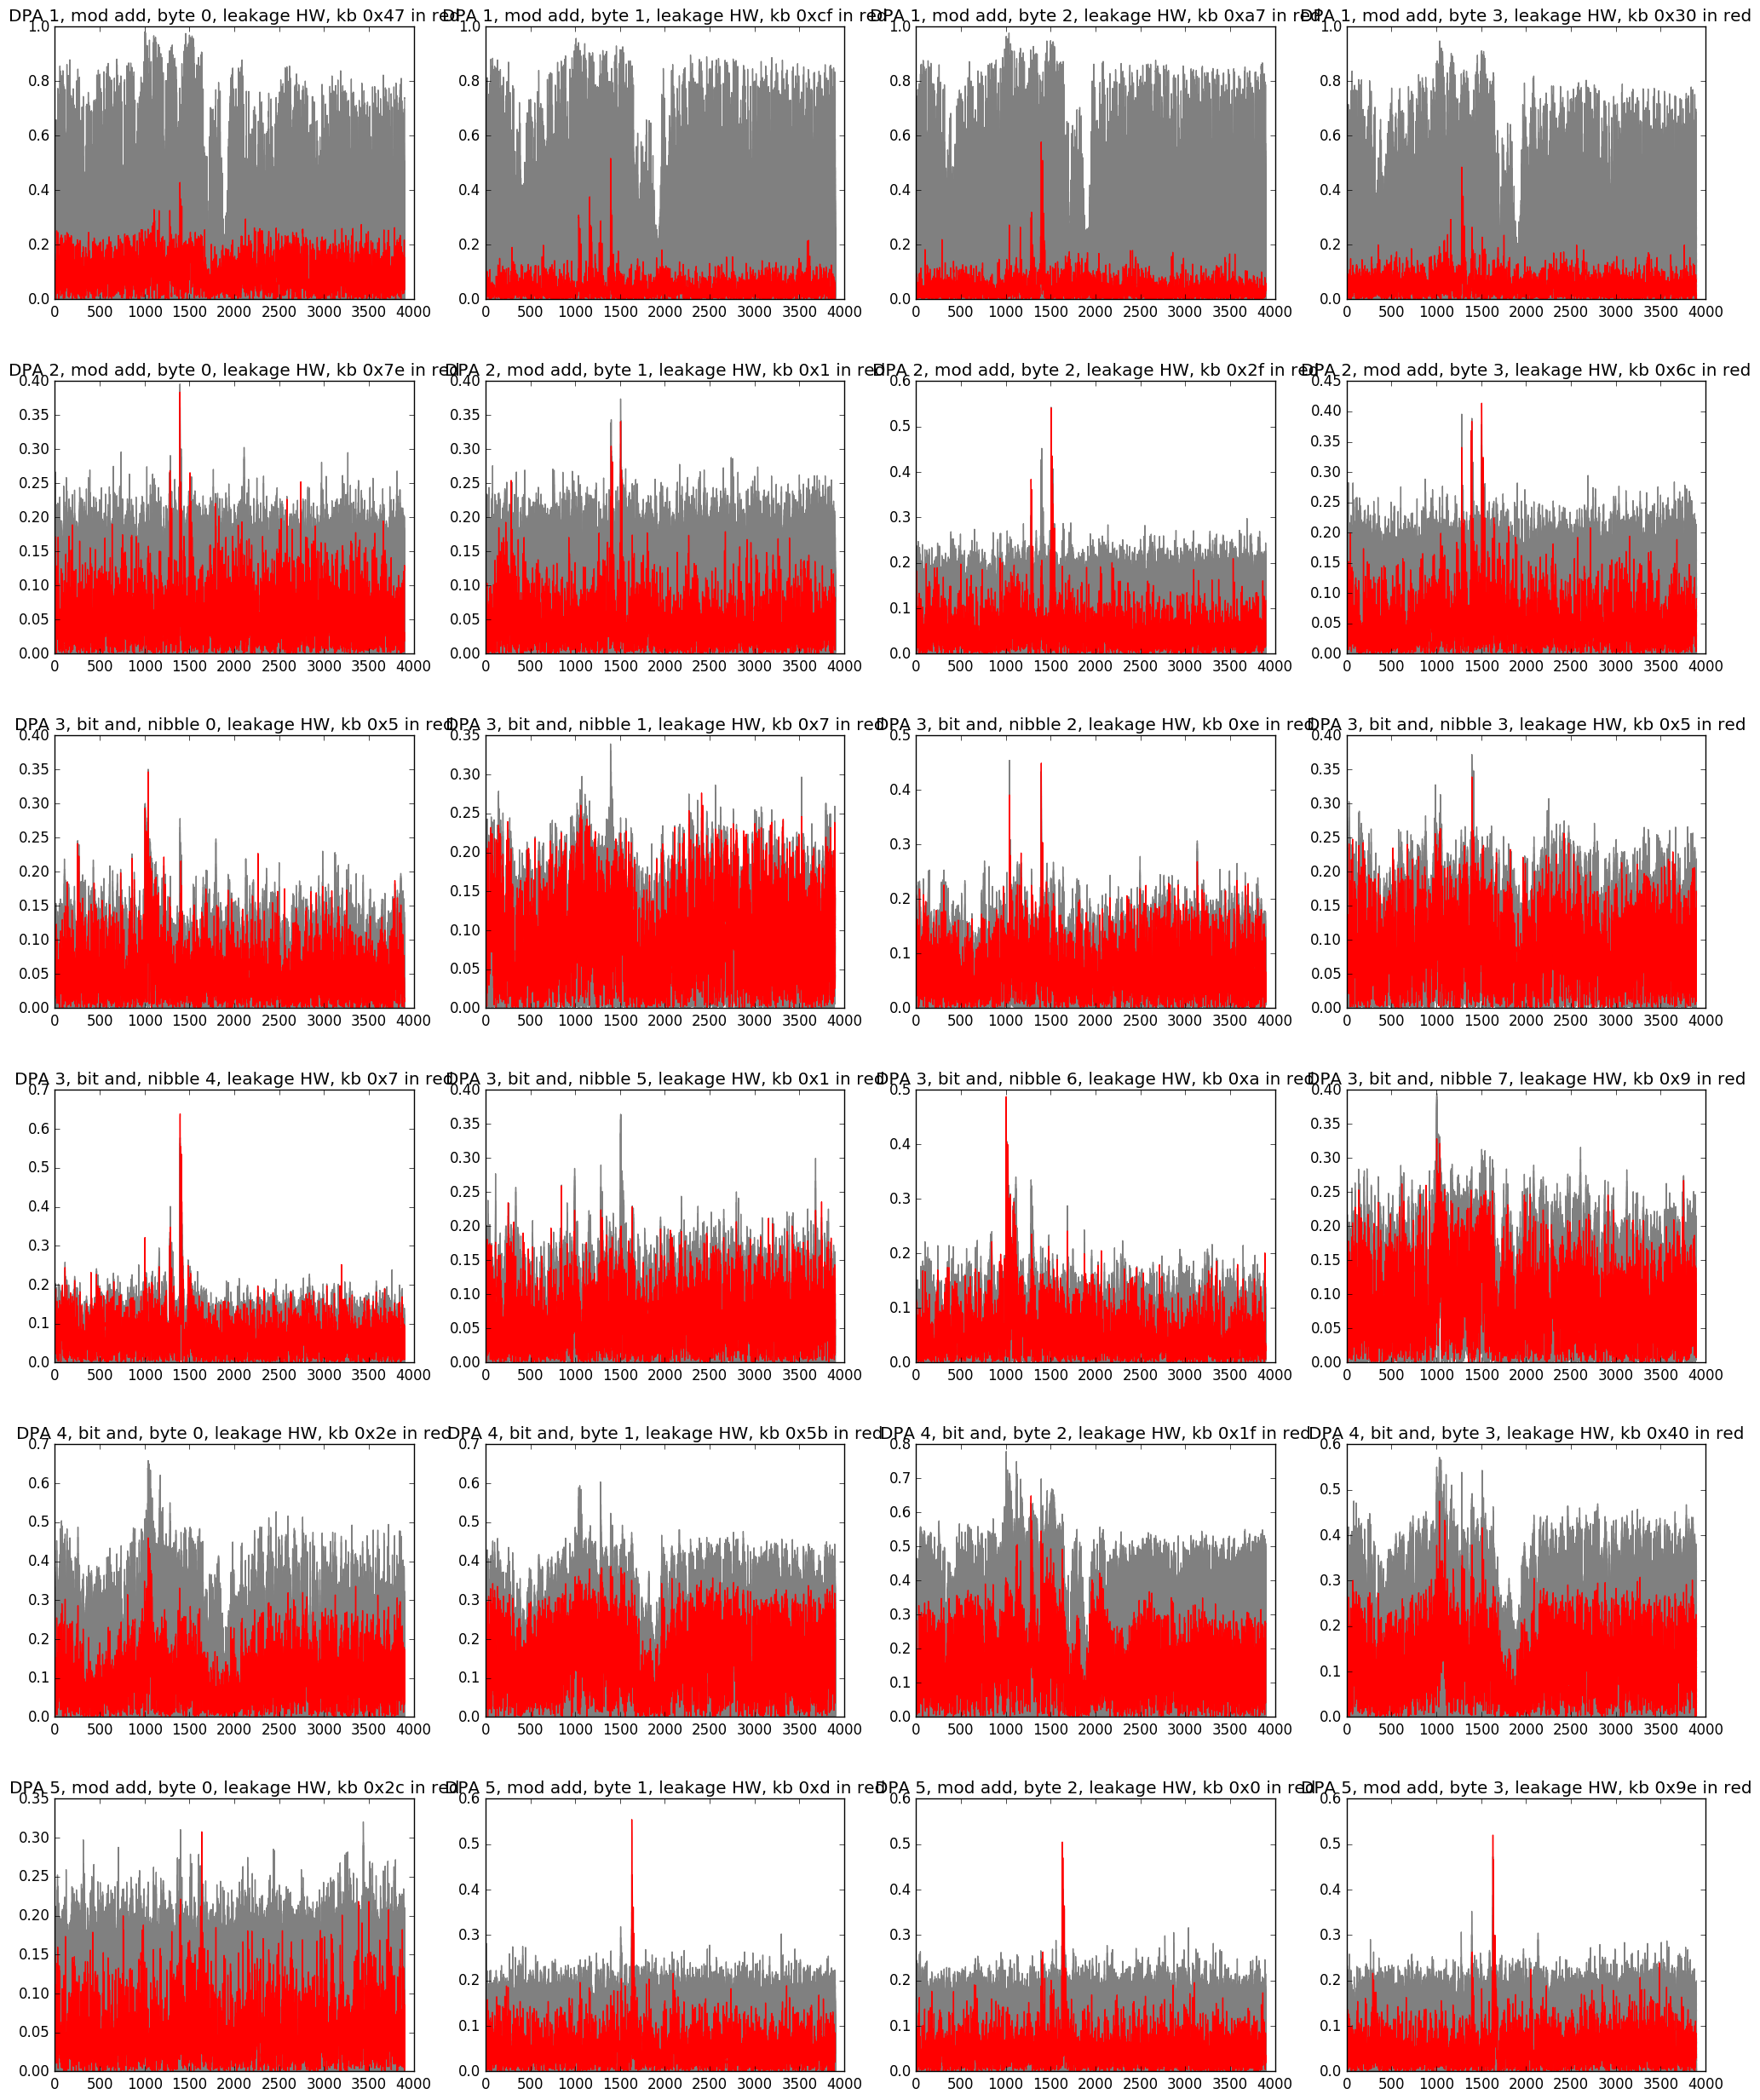

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [14]:
plotAll()

As you can see, it's not all bad for DPA 2 and 5. Unfortunately, the very first DPA 1 is not very good at all. Since all these DPA attacks depend on the success of the previous attack, it's not very hopeful. DPA 1 is bad because W0, the value under attacker control, is very similar to the predicted output T0. For the other DPA attacks this is not the case!

There turns out a way to make DPA 2 and 5 leak even better, and that's by exploiting the HD instead of the HW. For DPA 2, we'll predict HD(T0,T1) instead of HW(T1) and the DPA 5 HD(T1,T2) instead of HW(T2). This attack cannot be run with conditional averaging at the moment. Remember that previously each DPA on 32 bits actually is implemented by 4 DPA on 8-bits. With HD this changes, since each HD takes 16 bits input. This would mean that we end up with 65K different traces per intermediate input, which is currently ruining the conditional averaging code (my bad). Still, we can run this attack using incremental correlation, it just takes a bit longer.  Note that DPA attacks 1,3 and 4 are not using HD, that's because I don't know what the compute the HD with .. 

In [15]:
doinccpaHD()


Jlsca running in Julia version: 0.6.0, 3 processes/2 workers/10 threads per worker

SHA1 input attack parameters
T xor:      true (xor for T0 = 0)
analysis:   IncrementalCPA
leakages:   Jlsca.Sca.Leakage[HW]
data at:    1
known key:  685d79d6007d6cb9437d9393ce6eacdefbf69a0a

phase: 1 / 14, #targets 1

	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes
	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:40


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 1
rank:   1, candidate: 0x00, peak: 0.132001 @ 1037
rank:   2, candidate: 0x10, peak: 0.096528 @ 1037
rank:   3, candidate: 0xf0, peak: 0.096020 @ 1037
rank:   4, candidate: 0xc0, peak: 0.095887 @ 1037
rank: 167, correct  : 0x47, peak: 0.028898 @ 1037
recovered key material: 00

phase: 2 / 14, #targets 1
phase input: 47

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:44


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 2
rank:   1, candidate: 0x00, peak: 0.093779 @ 1037
rank:   2, candidate: 0x80, peak: 0.072906 @ 1056
rank:   3, candidate: 0xff, peak: 0.070792 @ 1037
rank:   4, candidate: 0xfe, peak: 0.059443 @ 1055
rank: 218, correct  : 0xcf, peak: 0.012465 @ 1043
recovered key material: 00

phase: 3 / 14, #targets 1
phase input: 47cf

	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes
	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:42


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 3
rank:   1, candidate: 0xff, peak: 0.124229 @ 1037
rank:   2, candidate: 0x7f, peak: 0.097198 @ 1037
rank:   3, candidate: 0xbf, peak: 0.077779 @ 1037
rank:   4, candidate: 0x00, peak: 0.076727 @ 1037
rank: 203, correct  : 0xa7, peak: 0.016415 @ 1396
recovered key material: ff

phase: 4 / 14, #targets 1
phase input: 47cfa7

	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes
	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:43


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 4
rank:   1, candidate: 0xff, peak: 0.136241 @ 1056
rank:   2, candidate: 0x00, peak: 0.110323 @ 1056
rank:   3, candidate: 0x7f, peak: 0.093147 @ 1056
rank:   4, candidate: 0xfe, peak: 0.081132 @ 1056
rank: 208, correct  : 0x30, peak: 0.014490 @ 1057
recovered key material: ff

phase: 5 / 14, #targets 1
phase input: 47cfa730

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:44


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 5
rank:   1, correct  : 0x7e, peak: 0.014311 @ 1283
rank:   2, candidate: 0x9e, peak: 0.011294 @ 1283
rank:   3, candidate: 0xbe, peak: 0.010922 @ 1283
rank:   4, candidate: 0xfe, peak: 0.010369 @ 1283
rank:   5, candidate: 0x5e, peak: 0.010300 @ 1283
recovered key material: 7e

phase: 6 / 14, #targets 1
phase input: 47cfa7307e

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:41


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 6
rank:   1, correct  : 0x01, peak: 0.020777 @ 1283
rank:   2, candidate: 0x81, peak: 0.015864 @ 1283
rank:   3, candidate: 0x05, peak: 0.012853 @ 1283
rank:   4, candidate: 0x41, peak: 0.012508 @ 1283
rank:   5, candidate: 0xc1, peak: 0.012074 @ 1283
recovered key material: 01

phase: 7 / 14, #targets 1
phase input: 47cfa7307e01

	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes
	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:41


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 7
rank:   1, correct  : 0x2f, peak: 0.018240 @ 1283
rank:   2, candidate: 0xaf, peak: 0.013376 @ 1283
rank:   3, candidate: 0x4f, peak: 0.012585 @ 1283
rank:   4, candidate: 0x6f, peak: 0.012169 @ 1283
rank:   5, candidate: 0x0f, peak: 0.012119 @ 1283
recovered key material: 2f

phase: 8 / 14, #targets 1
phase input: 47cfa7307e012f

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:40


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 8
rank:   1, correct  : 0x6c, peak: 0.015136 @ 1283
rank:   2, candidate: 0xec, peak: 0.011806 @ 1283
rank:   3, candidate: 0x7c, peak: 0.011383 @ 1283
rank:   4, candidate: 0x8c, peak: 0.010957 @ 1283
rank:   5, candidate: 0x74, peak: 0.010156 @ 1283
recovered key material: 6c

phase: 9 / 14, #targets 8
phase input: 47cfa7307e012f6c

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:05:25


IncrementalCPA produced (3900, 128) correlation matrix
Results @ 1228800 rows
target: 1, phase: 9
rank:   1, candidate: 0x0d, peak: 0.014322 @ 1006
rank:   2, candidate: 0x09, peak: 0.014279 @ 1006
rank:   3, candidate: 0x0c, peak: 0.014260 @ 1006
rank:   4, candidate: 0x08, peak: 0.014216 @ 1006
rank:   6, correct  : 0x05, peak: 0.014152 @ 1006
target: 2, phase: 9
rank:   1, candidate: 0x0d, peak: 0.017700 @ 1055
rank:   2, candidate: 0x09, peak: 0.017436 @ 1055
rank:   3, candidate: 0x0c, peak: 0.016735 @ 1055
rank:   4, candidate: 0x05, peak: 0.016614 @ 1055
rank:  11, correct  : 0x07, peak: 0.015476 @ 1055
target: 3, phase: 9
rank:   1, candidate: 0x03, peak: 0.014948 @ 1043
rank:   2, candidate: 0x01, peak: 0.014855 @ 1043
rank:   3, candidate: 0x07, peak: 0.014483 @ 1043
rank:   4, candidate: 0x05, peak: 0.014389 @ 1043
rank:  15, correct  : 0x0e, peak: 0.012862 @ 1043
target: 4, phase: 9
rank:   1, candidate: 0x09, peak: 0.018563 @ 1037
rank:   2, candidate: 0x01, peak: 0.018336

Processing traces 1:1228800.. 100% Time: 0:12:04


IncrementalCPA produced (3900, 1024) correlation matrix
Results @ 1228800 rows
target: 1, phase: 10
rank:   1, candidate: 0x74, peak: 0.094978 @ 1037
rank:   2, candidate: 0x34, peak: 0.080249 @ 1037
rank:   3, candidate: 0x76, peak: 0.068531 @ 1037
rank:   4, candidate: 0x36, peak: 0.066637 @ 1037
rank:  49, correct  : 0x2e, peak: 0.040402 @ 1037
target: 2, phase: 10
rank:   1, candidate: 0x53, peak: 0.046637 @ 1037
rank:   2, candidate: 0x51, peak: 0.046500 @ 1037
rank:   3, candidate: 0x52, peak: 0.044440 @ 1037
rank:   4, candidate: 0x50, peak: 0.043342 @ 1037
rank:  31, correct  : 0x5b, peak: 0.030732 @ 1002
target: 3, phase: 10
rank:   1, candidate: 0x38, peak: 0.081744 @ 1037
rank:   2, candidate: 0x78, peak: 0.079819 @ 1037
rank:   3, candidate: 0xb8, peak: 0.079452 @ 1037
rank:   4, candidate: 0xf8, peak: 0.078377 @ 1037
rank: 203, correct  : 0x1f, peak: 0.039077 @ 1037
target: 4, phase: 10
rank:   1, candidate: 0xd2, peak: 0.066894 @ 1056
rank:   2, candidate: 0xd0, peak: 0.0

Processing traces 1:1228800.. 100% Time: 0:03:38


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 11
rank:   1, correct  : 0x2c, peak: 0.015550 @ 1396
rank:   2, candidate: 0xac, peak: 0.011099 @ 1396
rank:   3, candidate: 0xec, peak: 0.010717 @ 1396
rank:   4, candidate: 0x6c, peak: 0.010054 @ 1396
rank:   5, candidate: 0x34, peak: 0.009568 @ 1396
recovered key material: 2c

phase: 12 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:39


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 12
rank:   1, correct  : 0x0d, peak: 0.018636 @ 1396
rank:   2, candidate: 0x8d, peak: 0.014295 @ 1396
rank:   3, candidate: 0x0f, peak: 0.012822 @ 1396
rank:   4, candidate: 0x4d, peak: 0.012762 @ 1396
rank:   5, candidate: 0x0e, peak: 0.011507 @ 1395
recovered key material: 0d

phase: 13 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c0d

	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes
	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:38


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 13
rank:   1, correct  : 0x00, peak: 0.018741 @ 1396
rank:   2, candidate: 0x80, peak: 0.014888 @ 1396
rank:   3, candidate: 0xc0, peak: 0.013032 @ 1396
rank:   4, candidate: 0x40, peak: 0.012827 @ 1396
rank:   5, candidate: 0x20, peak: 0.010789 @ 1396
recovered key material: 00

phase: 14 / 14, #targets 1
phase input: 47cfa7307e012f6c05070e0507010a092e5b1f402c0d00

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 1 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 1 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:03:42


IncrementalCPA produced (3900, 256) correlation matrix
Results @ 1228800 rows
target: 1, phase: 14
rank:   1, correct  : 0x9e, peak: 0.016637 @ 1396
rank:   2, candidate: 0x1e, peak: 0.015589 @ 1396
rank:   3, candidate: 0xde, peak: 0.012067 @ 1396
rank:   4, candidate: 0x5e, peak: 0.012067 @ 1396
rank:   5, candidate: 0x3e, peak: 0.010385 @ 1396
recovered key material: 9e
recovered key: 29de4f7648e14dd3437d9393cf72b3f0a23ee3ef
knownkey match: false
3710.947288 seconds (7.32 M allocations: 1.602 GiB, 0.06% gc time)


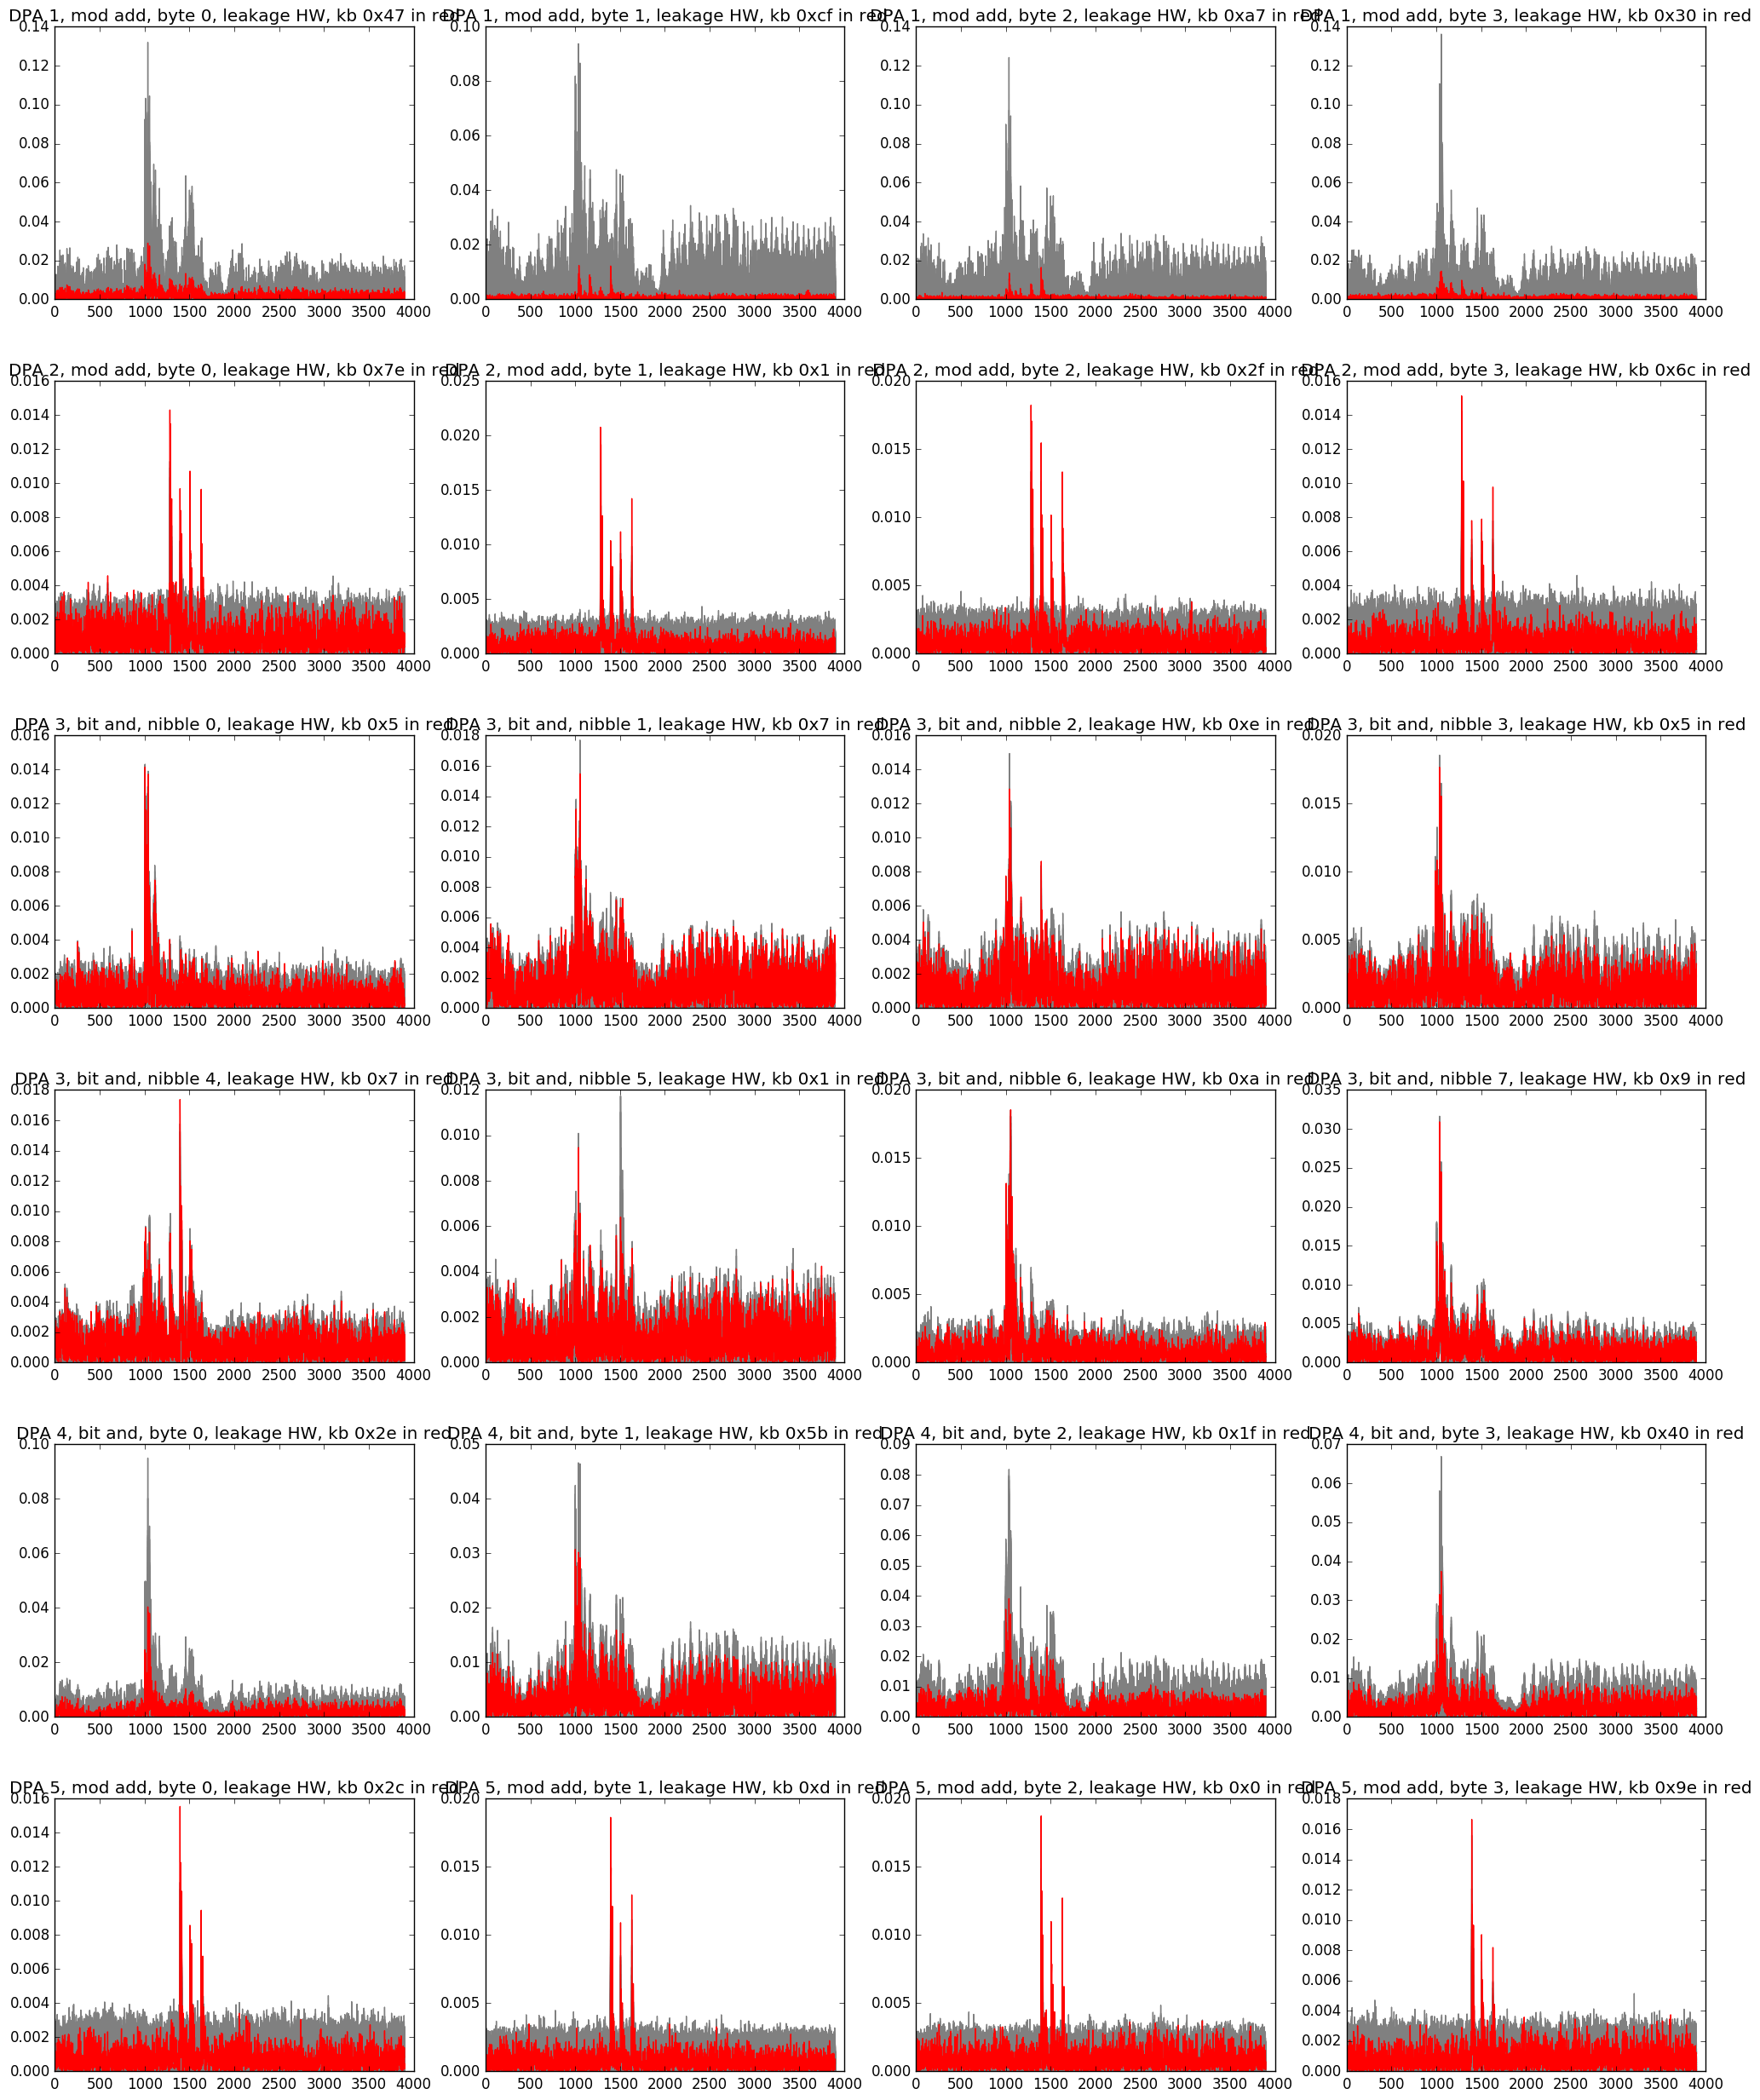

In [16]:
plotAll()